(1000, 12)
   day_of_week  is_weekend  month  store_area  promotion  holiday  \
0            6           1      7       103.3          1        0   
1            3           0     10        57.8          1        0   
2            4           0      3       212.9          0        0   
3            6           1      1       142.1          0        0   
4            2           0      5       266.1          1        0   

   price_index  competitor_distance_km  temperature_C  foot_traffic  \
0        1.042                    1.73           18.4         742.0   
1        0.985                    4.40            8.7         298.0   
2        0.938                    1.68           14.2         938.0   
3        1.074                    2.00           29.9         730.0   
4        0.942                    1.46           13.6         967.0   

   prev_day_sales    sales  
0           472.0  1772.70  
1           186.0  1755.96  
2           524.0  2555.90  
3           326.0  2099.44  
4 

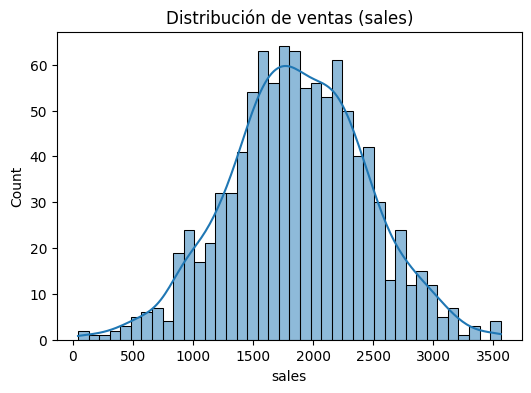

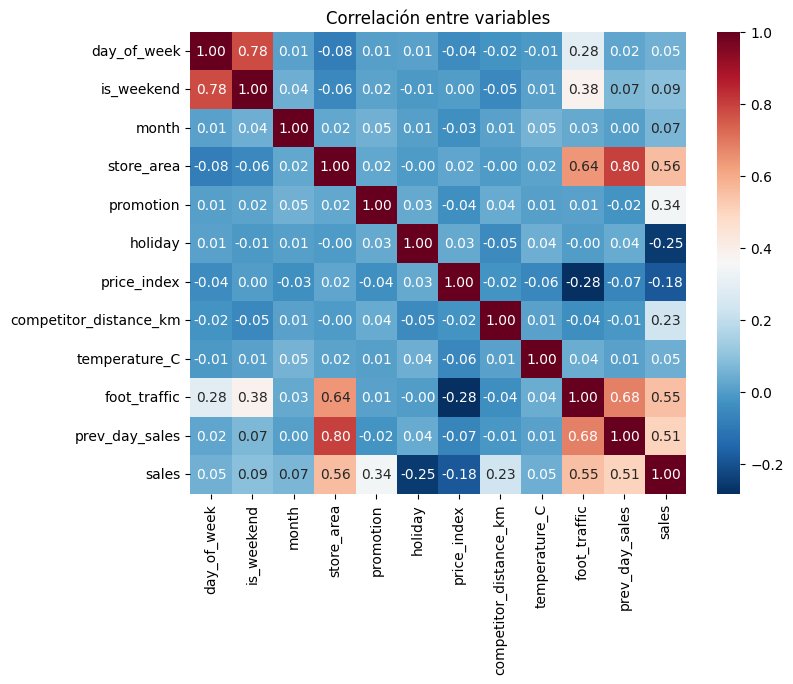

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("store_sales.csv")
print(df.shape)
print(df.head())
print(df.describe())

# Distribución target
plt.figure(figsize=(6,4))
sns.histplot(df['sales'], bins=40, kde=True)
plt.title("Distribución de ventas (sales)")
plt.show()

# Correlaciones (numéricas)
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="RdBu_r")
plt.title("Correlación entre variables")
plt.show()


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import joblib

df = pd.read_csv("store_sales.csv")

X = df.drop(columns=["sales"])
y = df["sales"]

# Train/test split — SIN transformar antes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

num_cols = ["store_area","price_index","competitor_distance_km",
            "temperature_C","foot_traffic","prev_day_sales"]

cat_cols = ["day_of_week","month"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), cat_cols),
    ],
    remainder="passthrough"
)

pipeline = Pipeline([
    ("pre", preprocessor),
    ("model", RandomForestRegressor(n_estimators=200, random_state=42))
])

pipeline.fit(X_train, y_train)

joblib.dump(pipeline, "sales_pipeline.joblib")
print("✅ Pipeline guardado")

sample = X_test.iloc[:3]
print("🔮 Predicciones:", pipeline.predict(sample))



✅ Pipeline guardado
🔮 Predicciones: [1551.1992 1509.2972 2072.8061]


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

lin_pipeline = Pipeline([
    ("pre", preprocessor),  # usa el mismo preprocesador!
    ("model", LinearRegression())
])

lin_pipeline.fit(X_train, y_train)

preds_lin = lin_pipeline.predict(X_test)

rmse_lin = np.sqrt(mean_squared_error(y_test, preds_lin))
r2_lin = r2_score(y_test, preds_lin)

print("Linear RMSE:", rmse_lin)
print("Linear R2:", r2_lin)



Linear RMSE: 367.35260549938397
Linear R2: 0.6062650764197715


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

lin_pipeline = Pipeline([
    ("pre", preprocessor),  # usa el mismo preprocesador!
    ("model", LinearRegression())
])

lin_pipeline.fit(X_train, y_train)

preds_lin = lin_pipeline.predict(X_test)

rmse_lin = np.sqrt(mean_squared_error(y_test, preds_lin))
r2_lin = r2_score(y_test, preds_lin)

print("Linear RMSE:", rmse_lin)
print("Linear R2:", r2_lin)



Linear RMSE: 367.35260549938397
Linear R2: 0.6062650764197715


In [5]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1, max_iter=10000),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42)
}

for name, model in models.items():
    pipe = Pipeline([
        ("pre", preprocessor),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    
    print(f"{name} → RMSE: {rmse:.3f}, R2: {r2:.3f}")



Ridge → RMSE: 366.995, R2: 0.607
Lasso → RMSE: 367.078, R2: 0.607
RandomForest → RMSE: 396.964, R2: 0.540


In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge_pipe = Pipeline([
    ("pre", preprocessor),
    ("model", Ridge())
])

params_ridge = {
    "model__alpha": [0.01, 0.1, 1.0, 5.0, 10.0]
}

grid_ridge = GridSearchCV(
    ridge_pipe,
    params_ridge,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

grid_ridge.fit(X_train, y_train)

print("Best Ridge params:", grid_ridge.best_params_)
print("Ridge RMSE (CV):", -grid_ridge.best_score_)



Best Ridge params: {'model__alpha': 1.0}
Ridge RMSE (CV): 362.67930789994125


In [7]:
from sklearn.ensemble import RandomForestRegressor

rf_pipe = Pipeline([
    ("pre", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

params_rf = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_leaf": [1, 3]
}

grid_rf = GridSearchCV(
    rf_pipe,
    params_rf,
    cv=4,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)
print("RF RMSE (CV):", -grid_rf.best_score_)


Best RF params: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__n_estimators': 200}
RF RMSE (CV): 392.42922403660964


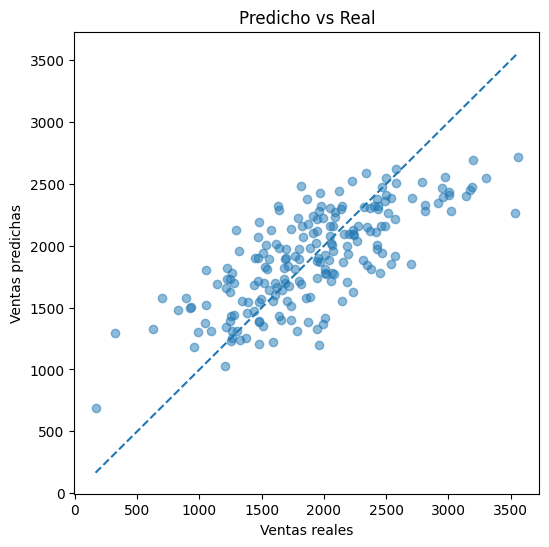

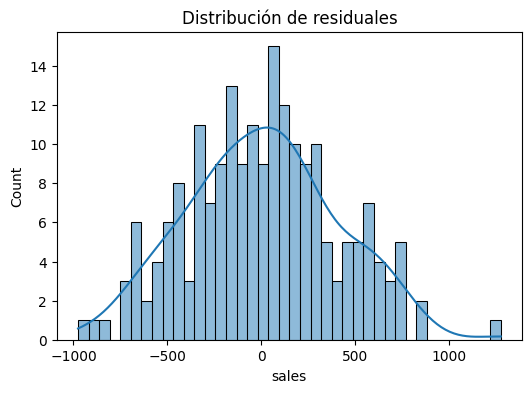

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

best_model = grid_rf.best_estimator_ if 'grid_rf' in globals() else grid_rf
preds = best_model.predict(X_test)

# Predicción vs Valor Real
plt.figure(figsize=(6,6))
plt.scatter(y_test, preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--')
plt.xlabel("Ventas reales")
plt.ylabel("Ventas predichas")
plt.title("Predicho vs Real")
plt.show()

# Residuales
residuals = y_test - preds
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Distribución de residuales")
plt.show()



In [12]:
import joblib

best_model = grid_rf.best_estimator_  # o grid_ridge
joblib.dump(best_model, "best_model.joblib")
print("✅ Best model saved: best_model.joblib")


✅ Best model saved: best_model.joblib
